# Convergence of MaxSum

In [262]:
include("../code/bp_full.jl")
include("../code/optimal_cycle.jl")
using ProgressMeter, StatsBase

### 1. Draw random instance and find ground state

In [263]:
# Build a random graph with variables of degree exactly 2
# Inputs: size, rate

include("../code/ldpc_graph.jl")
function cycle_code(n::Int, R::Real; rng=MersenneTwister(0))
    @assert 0≤R≤1
    m = round(Int, n*(1-R))
    nedges, Lambda, Rho = generate_polyn(n,m,degree_type=:nodes)
    nedges = 2n
    H = permutedims(ldpc_matrix(n,m,nedges,Lambda,Rho, accept_multi_edges=false,rng=rng))
end

cycle_code (generic function with 1 method)

In [264]:
# Given a ground state config `x_gs`, the energy of the first excited state:
# Force each variable in turn to take value opposite to what it had in `x_gs`,
#  then find the optimal solution with that variable constraint
# `x0` is the source

function first_excited(H::SparseMatrixCSC, x_gs::AbstractVector, x0::AbstractVector)
    n = length(x_gs)
    x = copy(x_gs)
    # w=1 does nothing
    w = zeros(Int, n)  
    d = zeros(n)
    for i in 1:n
#         x .= x_gs
        x .= false
        # set weight large enough to force flipping of x[i]
#         w[i] = -n
        w[i] = n * (x_gs[i]*2-1)
        # find optimal solution using the mapping to perfect matching
        d[i], _, _ = findsol(H, x0, x, weights=w, verbose=false)
        @assert x[i] != x_gs[i]
        # set weight back to default
        w[i] = 0
    end
    d
end

first_excited (generic function with 1 method)

In [265]:
n = 14
R = 0.5
rng_idx = 7
rng = MersenneTwister(rng_idx)
H = cycle_code(n, R; rng=rng)
x0 = bitrand(rng, n)   # source
global x_gs = falses(n)
d, dist, x_gs = findsol(H, x0, weights=zeros(Int,n))

LoadError: ArgumentError: indexed assignment with a single value to many locations is not supported; perhaps use broadcasting `.=` instead?

### 2. Find the energy shift to the first excited state
(Re-run the code if ground state degenerate)

In [222]:
D = first_excited(H, x_gs, x0);

In [223]:
d, minimum(D)

(0.14285714285714285, 0.14285714285714285)

In [175]:
ϵ = minimum(D) - d

0.0

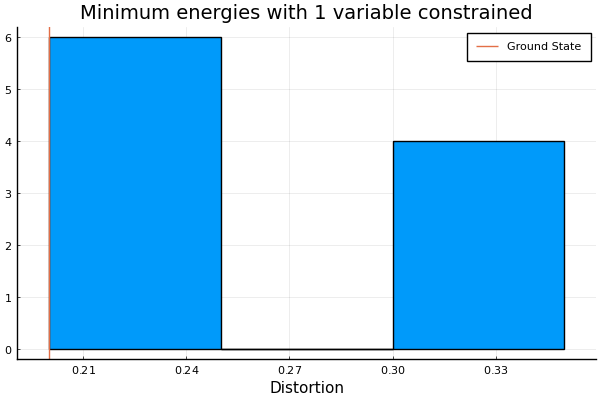

In [176]:
using Plots
histogram(D, label="")
vline!([d], label="Ground State")
xlabel!("Distortion")
title!("Minimum energies with 1 variable constrained")

### 3. Run MaxSum
for $k=\biggl\lceil\frac{nw^*}{\epsilon}\biggr\rceil$ iterations where $w^*=2$ is the maximum reward for flipping a variable

In [157]:
s = (-1) .^ x0
noise = 0.0 #1e-20
rng2 = MersenneTwister(rng_idx)
efield = [(ss+noise*randn(rng2),-float(ss)) for ss in s]
ms = BPFull(H, efield)
wstar = 2
k = ceil(Int, wstar*n/ϵ)

5001

In [158]:
# efield_vanishing = [(efield[i], (0.5,0.5)) for i in eachindex(efield)]
# ms = ms_full_vanishing(H, efield_vanishing) 

In [159]:
bit2int(x::BitVector) = sum(x[i]*2^(i-1) for i in eachindex(x))

bit2int (generic function with 1 method)

In [160]:
global dist = fill(NaN, k)
global nunsat = fill(NaN, k)
global X = fill(NaN, k)

function cb(it, ε, bp)
    mod(it, 10^4)==0 && println("Iter $it.\terr=$ε")
    s = map(t->sign(t[1]-t[2]), bp.efield)
    x = falses(length(s))
    nunsat_, _,dist_ = performance(bp, s, x)
    X[it] = bit2int(x)
#     @show it, size(nunsat)
    nunsat[it] = nunsat_; dist[it] = dist_
    decvars = argmax.(bp.belief) .== 2
#     decvars == x_gs && return true
    undec = sum(s.==0)
    undec>0 && println(undec, " undecided")
    false
end

cb (generic function with 1 method)

In [161]:
err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15, callback=cb)

(2.0, 5001)

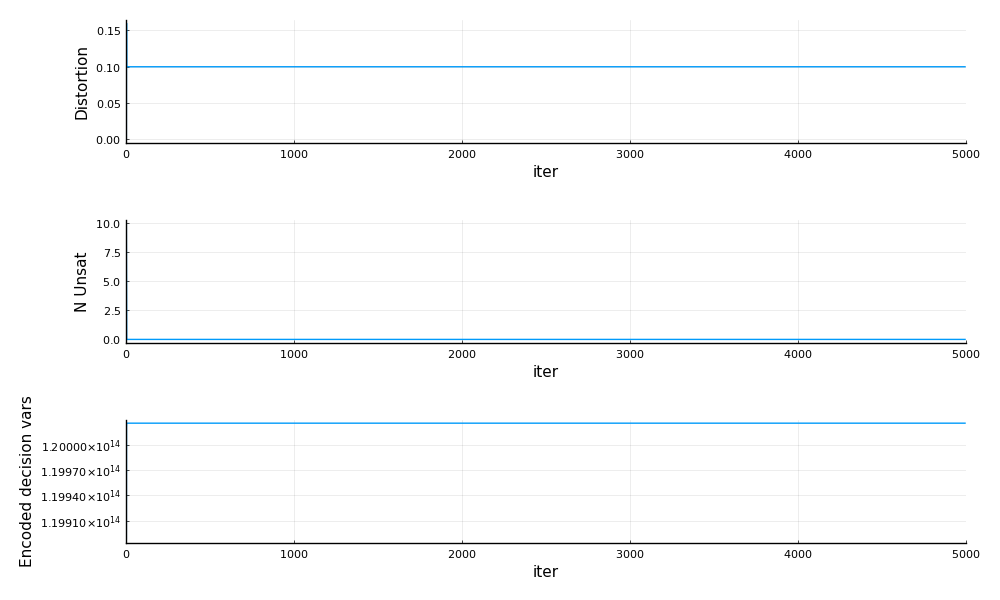

In [162]:
p1 = plot(dist, label="")
xlabel!(p1, "iter")
ylabel!(p1, "Distortion")
xlims!((0,iters))
p2 = plot(nunsat, label="")
xlabel!(p2, "iter")
ylabel!(p2, "N Unsat")
xlims!((0,iters))
p3 = plot(X, label="")
xlabel!(p3, "iter")
ylabel!(p3, "Encoded decision vars")
xlims!((0,iters))
plot(p1,p2,p3,layout=(3,1), size=(1000,600), margin=5Plots.mm)

In [15]:
x_ms = (argmax.(ms.belief) .== 2);
# beliefs = [t[1]-t[2] for t in ms.belief]
# beliefs_hist = sort(proportionmap(beliefs))

In [16]:
a,b,c = performance(ms, s)
println(a, " unsat. Distance of decision vars from source = ", c)

0 unsat. Distance of decision vars from source = 0.1


In [17]:
@show x_gs == x_ms
dist[iters], d

x_gs == x_ms = true


(0.1, 0.1)

In [18]:
i = findfirst(x_gs .!= x_ms)

In [19]:
w = zeros(Int, n)  
w[i] = n * (x_gs[i]*2-1)
# find optimal solution using the mapping to perfect matching
_, _, x = findsol(H, x0, falses(n), weights=w, verbose=false)
parity(H,x), sum(x .!= x0)
# @assert x[i] != x_gs[i]

LoadError: ArgumentError: invalid index: nothing of type Nothing

## 4. Try small examples

In [229]:
function single_example_cycle(n::Int, R::Real, rng_idx::Int, noise::Real=0.0, wstar=2)
    rng = MersenneTwister(rng_idx)
    H = cycle_code(n, R; rng=rng)
    x0 = bitrand(rng, n)   # source
    d, dist, x_gs = findsol(H, x0, weights=zeros(Int,n), verbose=false)
    D = first_excited(H, x_gs, x0)
    ε = n*(minimum(D) - d)
    ε, x0, H, x_gs, rng
end

function single_example_ms(x0::BitVector, rng::AbstractRNG, H::SparseMatrixCSC, noise::Real=0.0)
    s = (-1) .^ x0
    efield = [(ss+noise*randn(rng),-float(ss)) for ss in s]
    ms = BPFull(H, efield)
    ms
end

single_example_ms (generic function with 2 methods)

In [230]:
function small_examples(n::Int, R::Real, N::Int, noise::Real=0.0)
    ε = fill(NaN, N)
    nonmatched = zeros(Int, 0)
    @showprogress for i in 1:N
        ε[i], x0, H, x_gs, rng = single_example_cycle(n, R, i, noise)
        if ε[i] != 0
            k = ceil(Int, wstar*n^2/ε[i])
            ms = single_example_ms(x0, rng, H)
            err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15)
            x_ms = (argmax.(ms.belief) .== 2)
            x_ms!=x_gs && push!(nonmatched, i)  
        end
    end
    ε, nonmatched
end

small_examples (generic function with 2 methods)

In [239]:
n = 14
R = 0.5
N = 500
noise = 1e-2

0.01

In [240]:
ε, nonmatched = small_examples(n, R, N, noise)
length(nonmatched)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


8

In [241]:
i = nonmatched[6]
ε[i], x0, H, x_gs, rng = single_example_cycle(n, R, i, noise)
k = ceil(Int, wstar*n^2/ε[i])
ms = single_example_ms(x0, rng, H, noise)
global dist = fill(NaN, k)
global nunsat = fill(NaN, k)
global X = fill(NaN, k)
global nchanged_msg = fill(NaN, k)
global nchanged_var = fill(NaN, k)
err, iters = iteration_ms!(ms, maxiter=k, tol=1e-15, callback=cb)
x_ms = (argmax.(ms.belief) .== 2)
@show parity(H, x_ms)
@show sum(x_gs .!= x_ms)
@show mean(x_gs.!=x0), mean(x_ms.!=x0);

parity(H, x_ms) = 2
sum(x_gs .!= x_ms) = 5
(mean(x_gs .!= x0), mean(x_ms .!= x0)) = (0.14285714285714285, 0.5)


In [242]:
k = ceil(Int, wstar*n^2/ε[i])
ε[i], k

(1.0, 392)

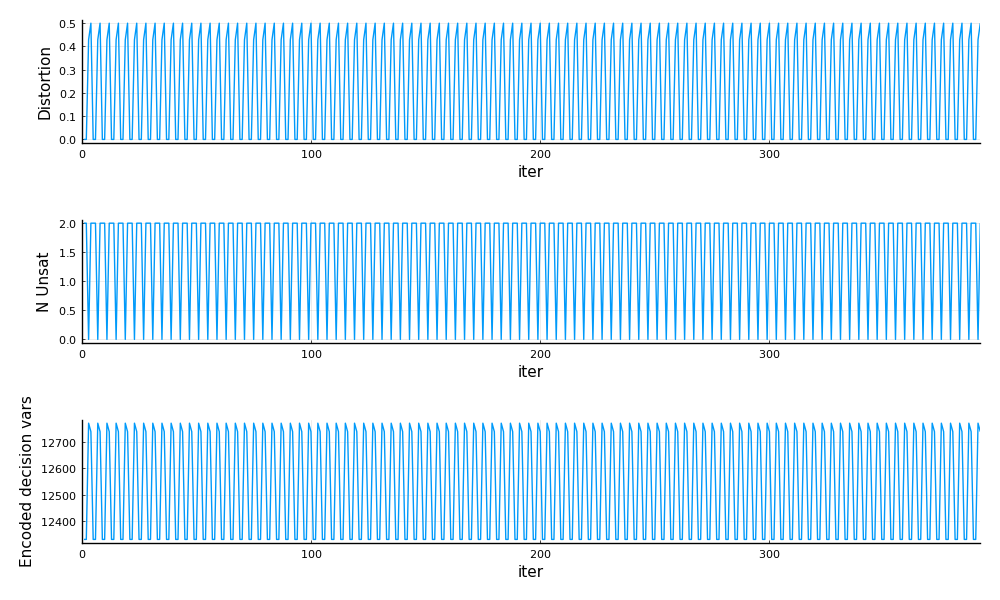

In [243]:
p1 = plot(dist, label="")
xlabel!(p1, "iter")
ylabel!(p1, "Distortion")
xlims!((0,iters))
p2 = plot(nunsat, label="")
xlabel!(p2, "iter")
ylabel!(p2, "N Unsat")
xlims!((0,iters))
p3 = plot(X, label="")
xlabel!(p3, "iter")
ylabel!(p3, "Encoded decision vars")
xlims!((0,iters))
plot(p1,p2,p3,layout=(3,1), size=(1000,600), margin=5Plots.mm)

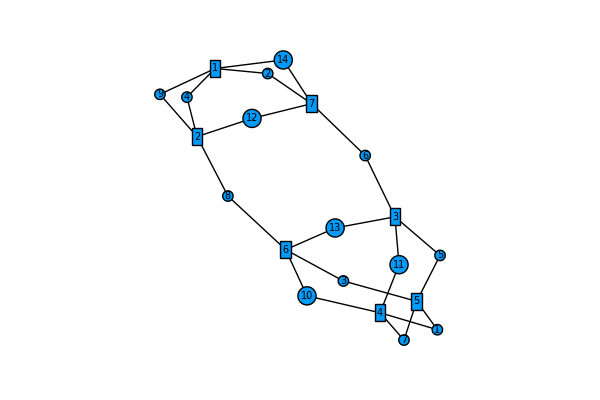

┌ Warning: Indices Base.OneTo(21) of attribute `markershape` does not match data indices 1:1175.
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Info: Data contains NaNs or missing values, and indices of `markershape` vector do not match data indices.
│ If you intend elements of `markershape` to apply to individual NaN-separated segements in the data,
│ pass each segment in a separate vector instead, and use a row vector for `markershape`. Legend entries 
│ may be suppressed by passing an empty label.
│ For example,
│     plot([1:2,1:3], [[4,5],[3,4,5]], label=["y" ""], markershape=[1 2])
└ @ Plots /home/crotti/.julia/packages/Plots/SVksJ/src/utils.jl:104


In [244]:
include("../code/plotters/plot_graph.jl")
plot(H, randseed=1)

In [245]:
Array(H)

7×14 Matrix{Bool}:
 0  1  0  1  0  0  0  0  1  0  0  0  0  1
 0  0  0  1  0  0  0  1  1  0  0  1  0  0
 0  0  0  0  1  1  0  0  0  0  1  0  1  0
 1  0  0  0  0  0  1  0  0  1  1  0  0  0
 1  0  1  0  1  0  1  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  1  0  1  0  0  1  0
 0  1  0  0  0  1  0  0  0  0  0  1  0  1

In [247]:
idx = [1,7,2,14,4,9]
[x0[idx] x_ms[idx] x_gs[idx]]

6×3 BitMatrix:
 0  1  0
 0  1  0
 0  0  0
 1  1  1
 1  0  1
 0  1  0

In [252]:
x0[[2,14]]

2-element BitVector:
 0
 1

In [251]:
x_gs
x2 = copy(x_gs)
x2[2] = 1; x2[14] = 0;
@show parity(H, x2)
mean(x2 .!= x0), mean(x_gs .!= x0)

parity(H, x2) = 0


(0.2857142857142857, 0.14285714285714285)

In [214]:
ε[i], x0, H, x_gs, rng = single_example_cycle(n, R, i, noise)
ms = single_example_ms(x0, rng, H, noise);

LoadError: BoundsError: attempt to access Tuple{Float64, BitVector, SparseMatrixCSC{Bool, Int64}, BitVector, MersenneTwister} at index [6]